<a href="https://colab.research.google.com/github/ritwiks9635/Object_Recognition_And_Detection-/blob/main/Face_Detection_using_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Face Detection**

In [ ]:
#https://www.kaggle.com/datasets/viniciodesouzacosta/caltech-102

In [ ]:
!unzip /content/https:/www.kaggle.com/datasets/viniciodesouzacosta/caltech-102/caltech-102.zip

In [ ]:
#!pip install keras --upgrade

In [ ]:
import numpy as np
import keras
from keras import layers
from keras import ops
import matplotlib.pyplot as plt
import numpy as np
import cv2
import scipy.io
import shutil

###**Hyperparameter**

In [ ]:
img_size = 224
input_shape = (img_size, img_size, 3)  # input image shape
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
patch_size = 32
num_epochs = 100
num_patches = (img_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
# Size of the transformer layers
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 4
mlp_head_units = [2048, 1024, 512, 64, 32]  # Size of the dense layers

###**Preprocessing Dataset**

In [ ]:
img_dir = "/content/caltech-101/101_ObjectCategories/101_ObjectCategories/Faces/"
annot_dir = "/content/caltech-101/Annotations/Annotations/Faces_2/"

image_paths = [f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f))]

annot_paths = [f for f in os.listdir(annot_dir) if os.path.isfile(os.path.join(annot_dir, f))]

image_paths.sort()
annot_paths.sort()


images = []
targets = []

for i in range(0, len(annot_paths)):
    annot = scipy.io.loadmat(annot_dir + annot_paths[i])["box_coord"][0]

    top_l_x, top_l_y = annot[2], annot[0]
    bottom_r_x, bottom_r_y = annot[3], annot[1]

    image = keras.utils.load_img(img_dir + image_paths[i])

    w, h = image.size[:2]

    image = image.resize((img_size, img_size))

    images.append(keras.utils.img_to_array(image))

    targets.append(
        (
            float(top_l_x) / w,
            float(top_l_y) / h,
            float(bottom_r_x) / w,
            float(bottom_r_y) / h
        ))

val_splits = int(len(images) * 0.8)
#print(val_splits)


(x_train), (y_train) = (
    np.asarray(images[: val_splits]),
    np.asarray(targets[: val_splits]),
)
(x_test), (y_test) = (
    np.asarray(images[val_splits :]),
    np.asarray(targets[val_splits :]),
)

###**Multilayer perceptron**

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation = keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

###**Patching**

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size


    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channel = input_shape[3]

        num_patch_h = height // self.patch_size
        num_patch_w = width // self.patch_size

        patches = ops.image.extract_patches(images, size = self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patch_h * num_patch_w,
                self.patch_size * self.patch_size * channel
            )
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size" : self.patch_size})
        return config

Image size: 224 X 224
Patch size: 32 X 32
49 patches per image 
3072 elements per patch


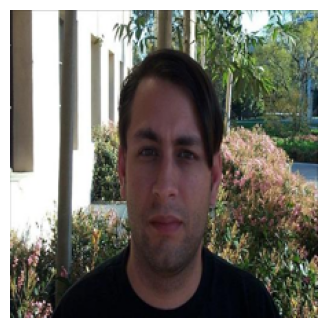

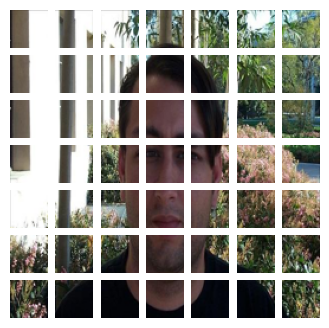

In [ ]:
plt.figure(figsize=(4, 4))
plt.imshow(x_train[300].astype("uint8"))
plt.axis("off")

patches = Patches(patch_size)(np.expand_dims(x_train[300], axis = 0))
print(f"Image size: {img_size} X {img_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"{patches.shape[1]} patches per image \n{patches.shape[-1]} elements per patch")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

plt.show()

###**Patch Encoder**

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units = projection_dim)
        self.pos_embed = layers.Embedding(input_dim = num_patches, output_dim = projection_dim)

    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config


    def call(self,patch):
        position = ops.expand_dims(ops.arange(start = 0, stop = self.num_patches, step = 1), axis = 0)
        projected_patchs = self.projection(patch)
        encoded_patches = projected_patchs + self.pos_embed(position)

        return encoded_patches

###**ViT Model**

In [ ]:
def build_vit_model(input_shape, patch_size, num_patches, projection_dim, num_heads, transformer_units, transformer_layers, mlp_head_units):
    inputs = keras.Input(shape=input_shape)
    # Create patches
    patches = Patches(patch_size)(inputs)
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.3)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.3)

    bounding_box = layers.Dense(4)(features)
    # Final four neurons that output bounding box

    # return Keras model.
    return keras.Model(inputs=inputs, outputs=bounding_box)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 105s 5s/step - loss: 1.3641 - val_loss: 0.4151
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 59s 99ms/step - loss: 0.5860 - val_loss: 0.3396
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.3460 - val_loss: 0.3174
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - loss: 0.3117 - val_loss: 0.2924
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - loss: 0.2903 - val_loss: 0.2671
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.2831 - val_loss: 0.2423
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.2173 - val_loss: 0.2193
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.2014 - val_loss: 0.1975
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.1794 - val_loss: 0.1770
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - loss: 0.1608 - val_loss: 0.1578
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 0.1440 - val_loss: 0.1400
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 228m

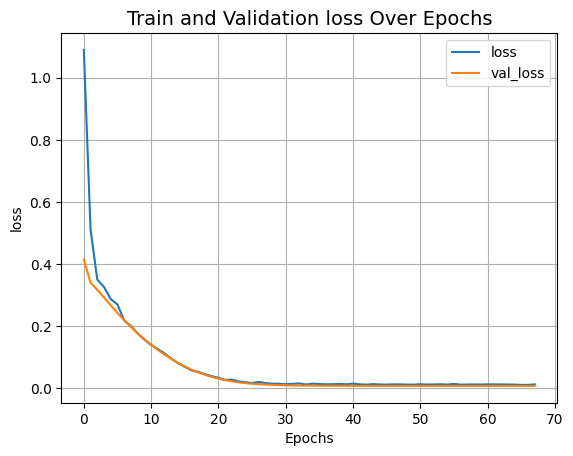

In [ ]:
def run_experimental(model, learning_rate, weight_decay, batch_size, num_epochs):
    optimizer = keras.optimizers.AdamW(learning_rate = learning_rate, weight_decay = weight_decay)
    model.compile(optimizer = optimizer, loss = keras.losses.MeanSquaredError())

    checkpoint_callbacks = keras.callbacks.ModelCheckpoint(
        "vit_model.weights.h5",
        monitor = "val_loss",
        save_best_only = True,
        save_weights_only = True)


    early_stopping_cb = keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10)

    callbacks = [checkpoint_callbacks, early_stopping_cb]

    history = model.fit(
        x_train,
        y_train,
        batch_size = batch_size,
        validation_split = 0.1,
        epochs = num_epochs,
        callbacks = callbacks)

    return history

history = []

vit_model = build_vit_model(input_shape, patch_size, num_patches, projection_dim, num_heads, transformer_units, transformer_layers, mlp_head_units)
history = run_experimental(vit_model, learning_rate, weight_decay, batch_size, num_epochs)


def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")

###**Predict Bounding Box**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
mean_iou: 0.7661183773983362


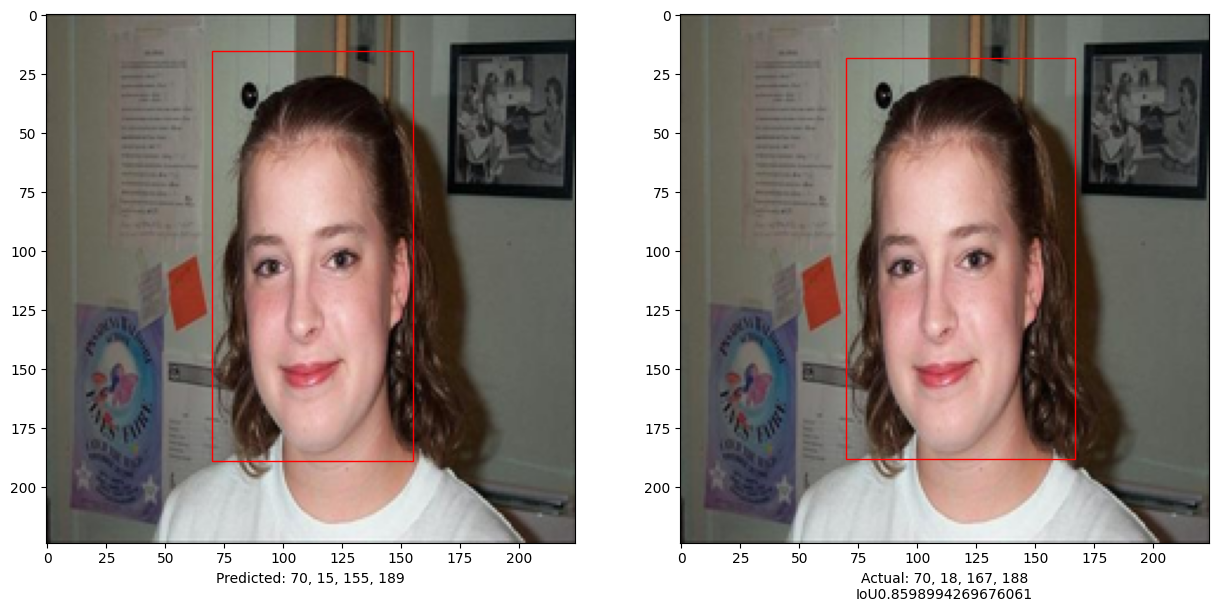

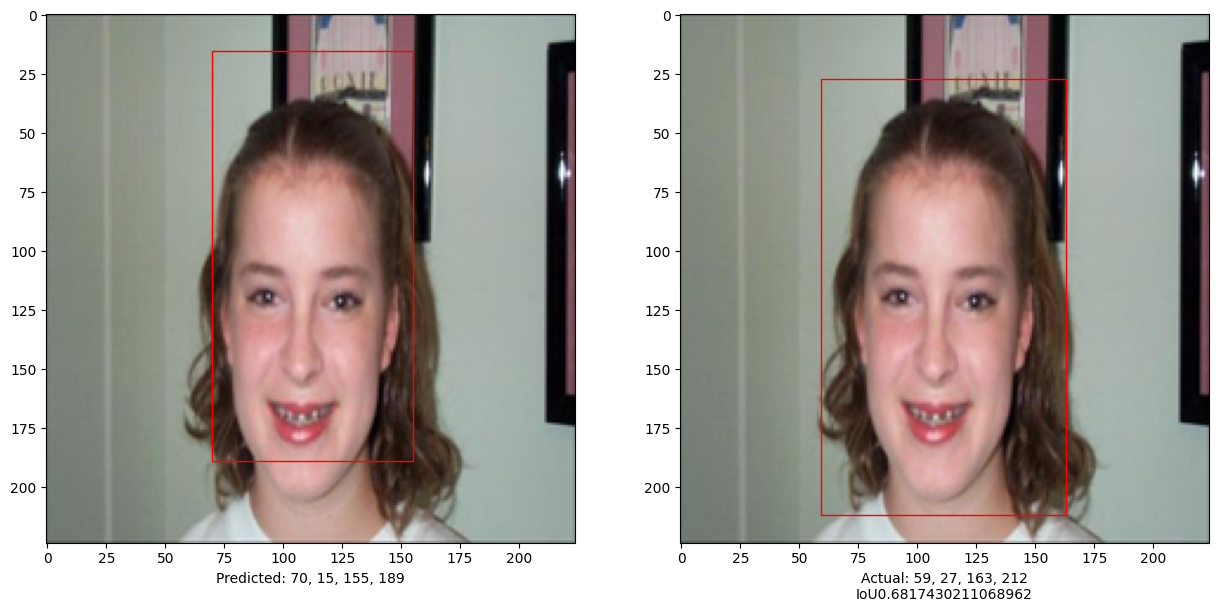

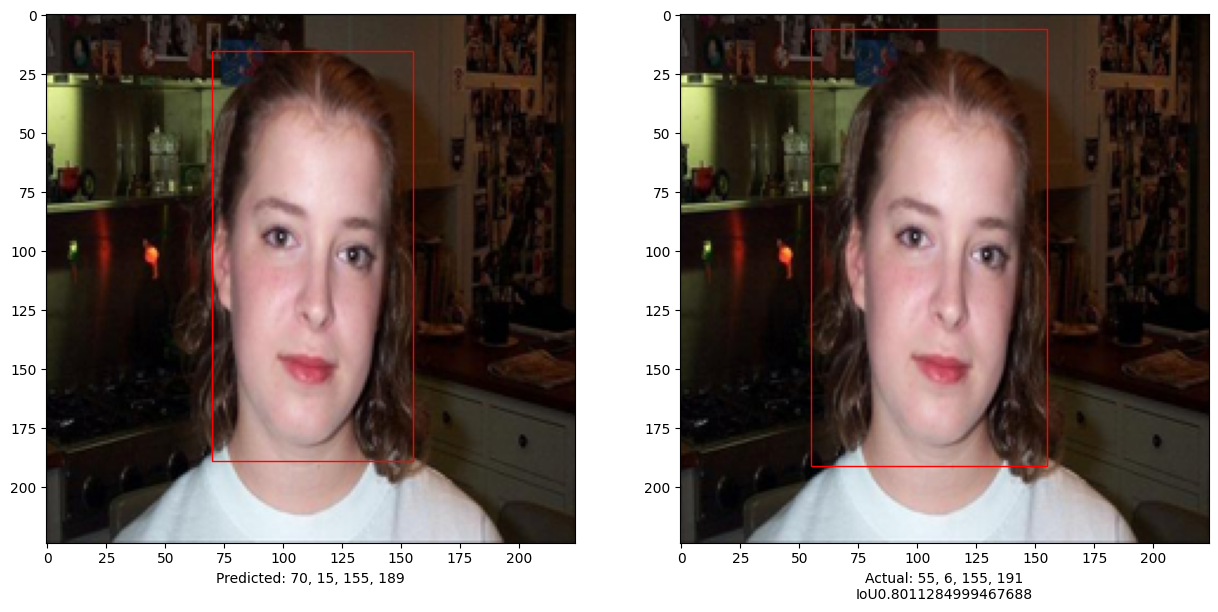

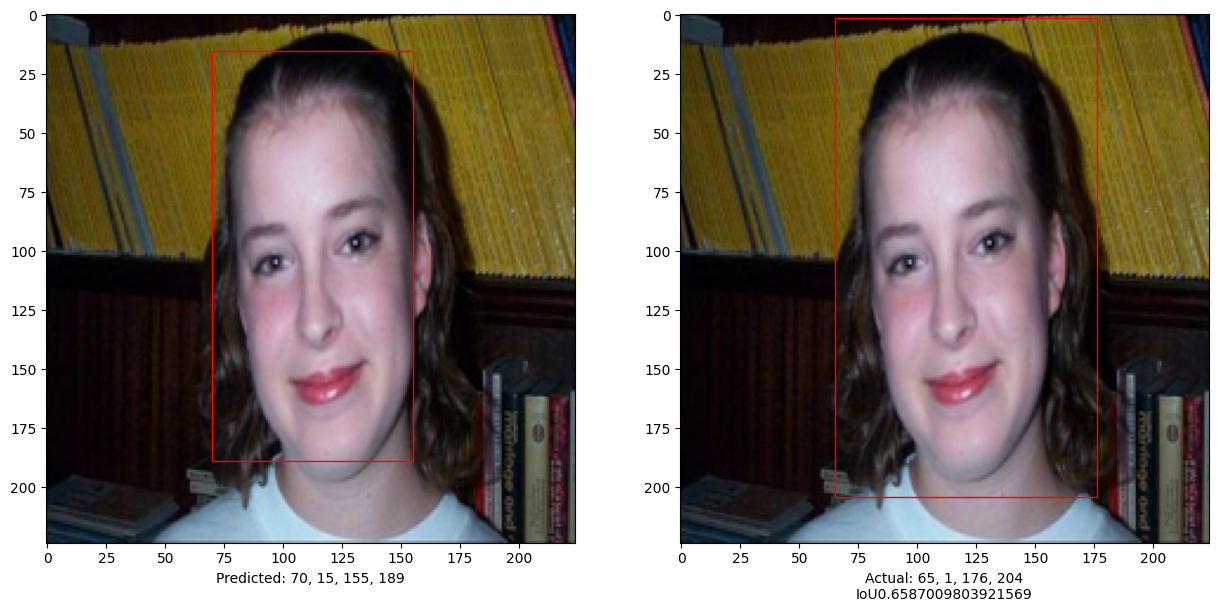

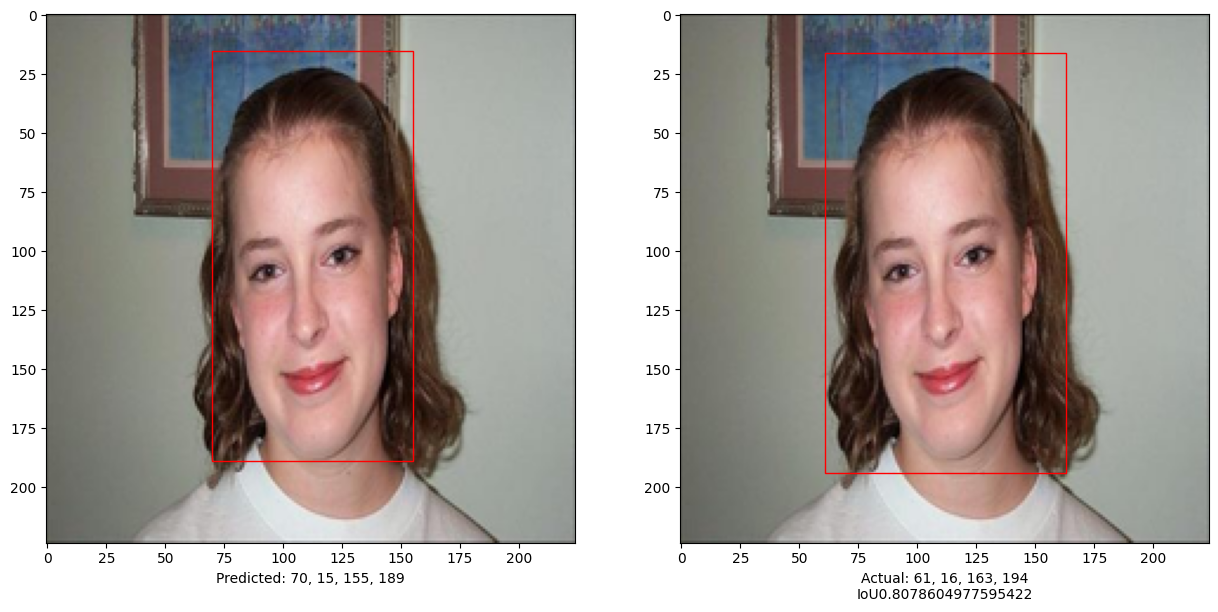

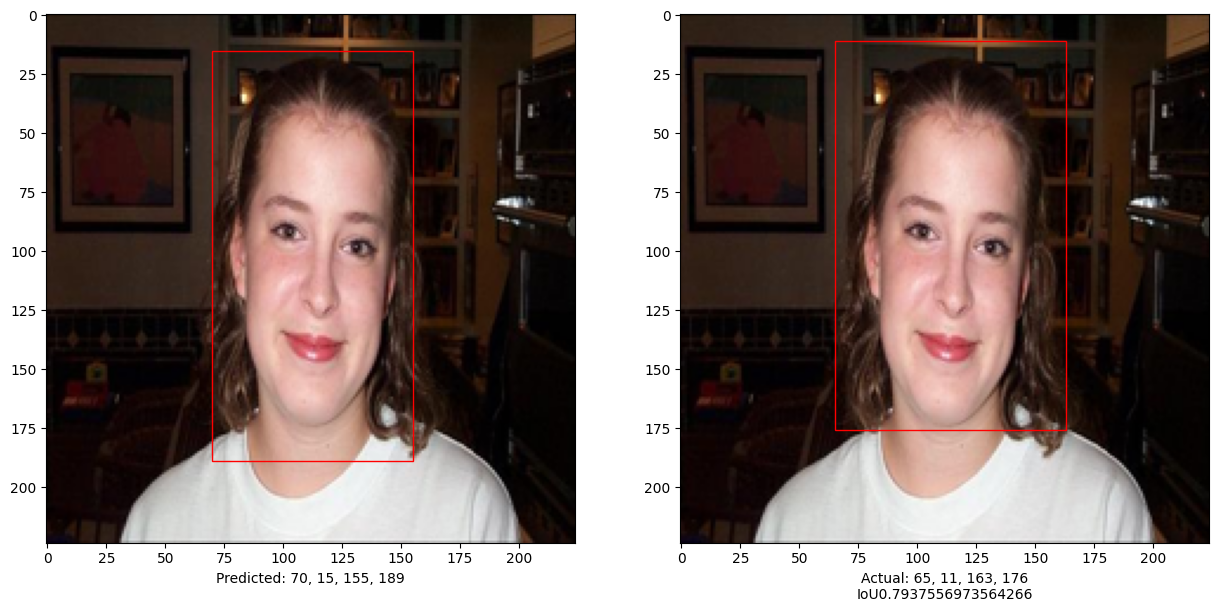

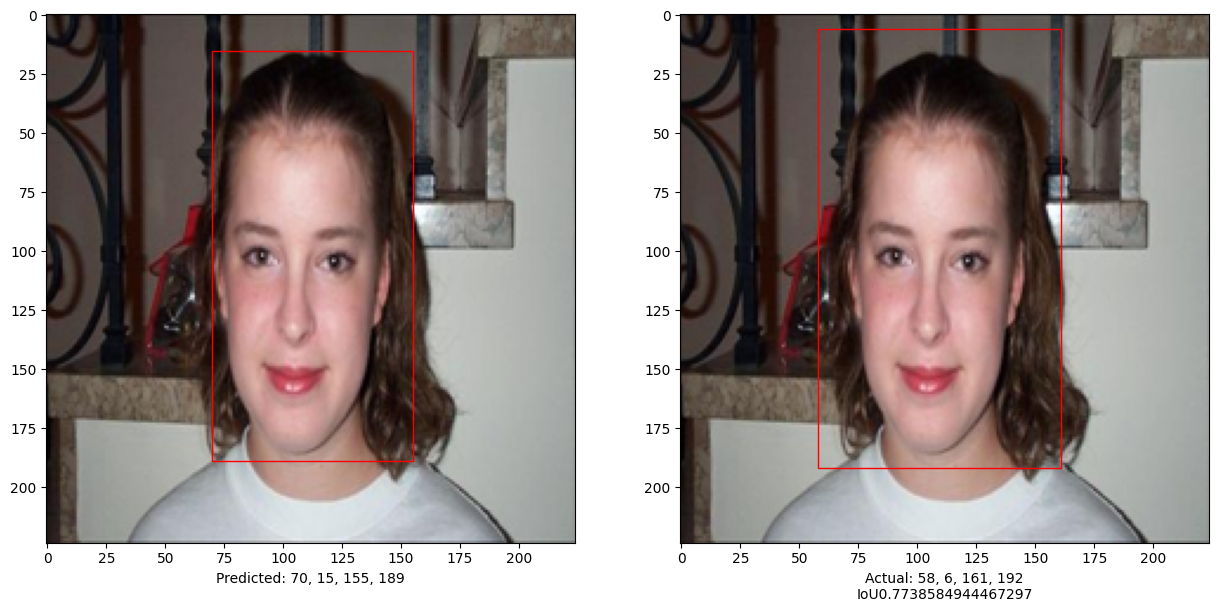

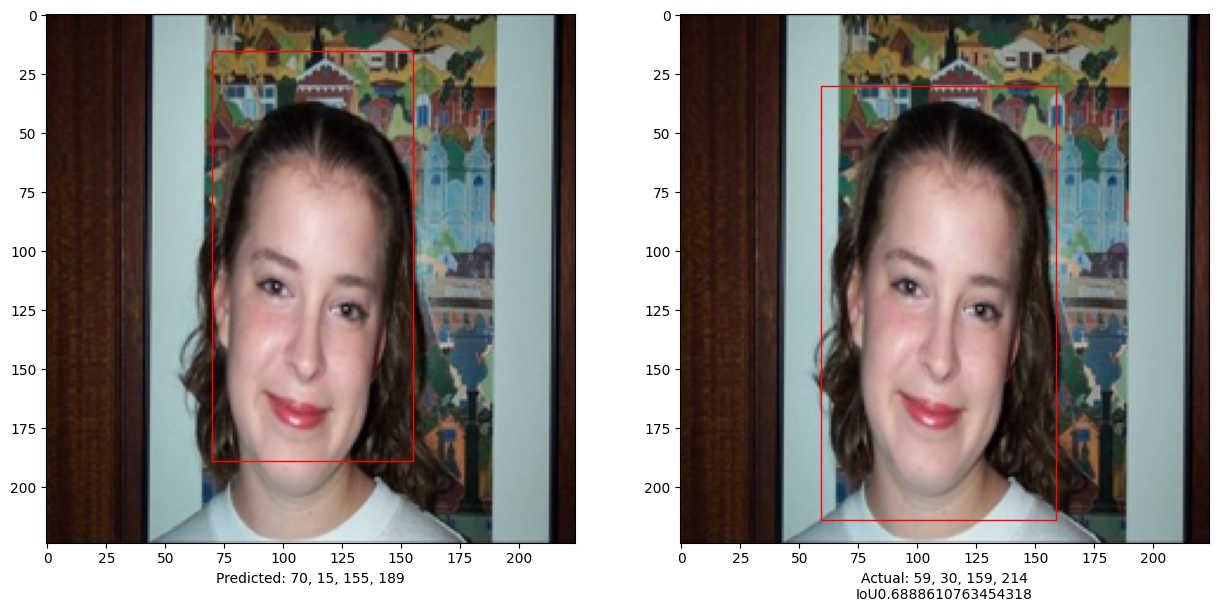

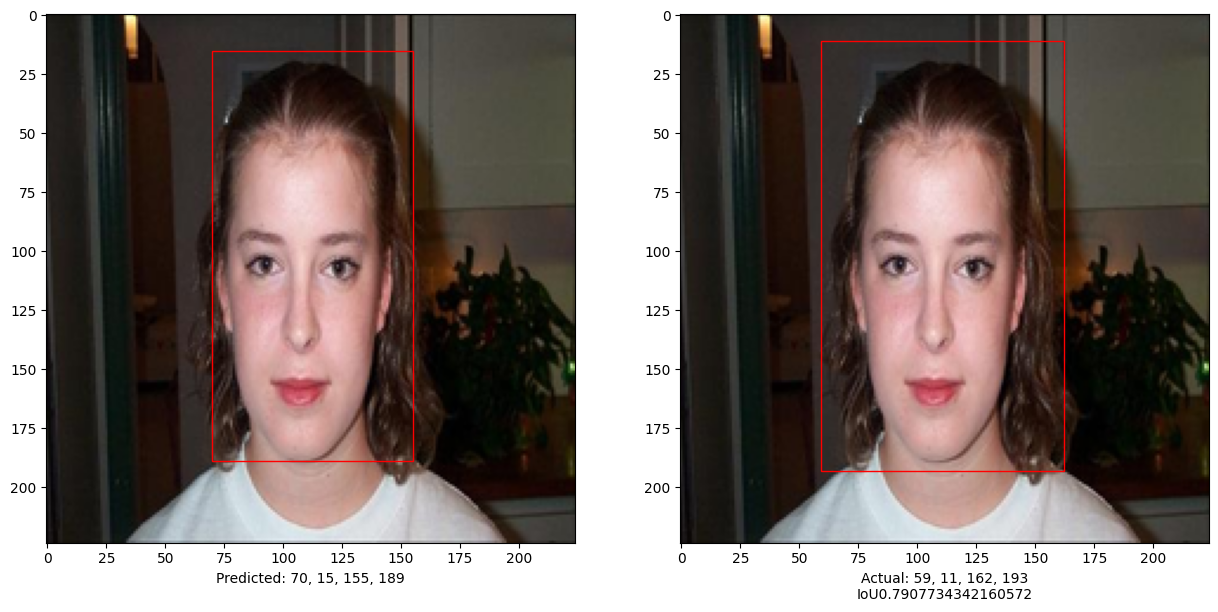

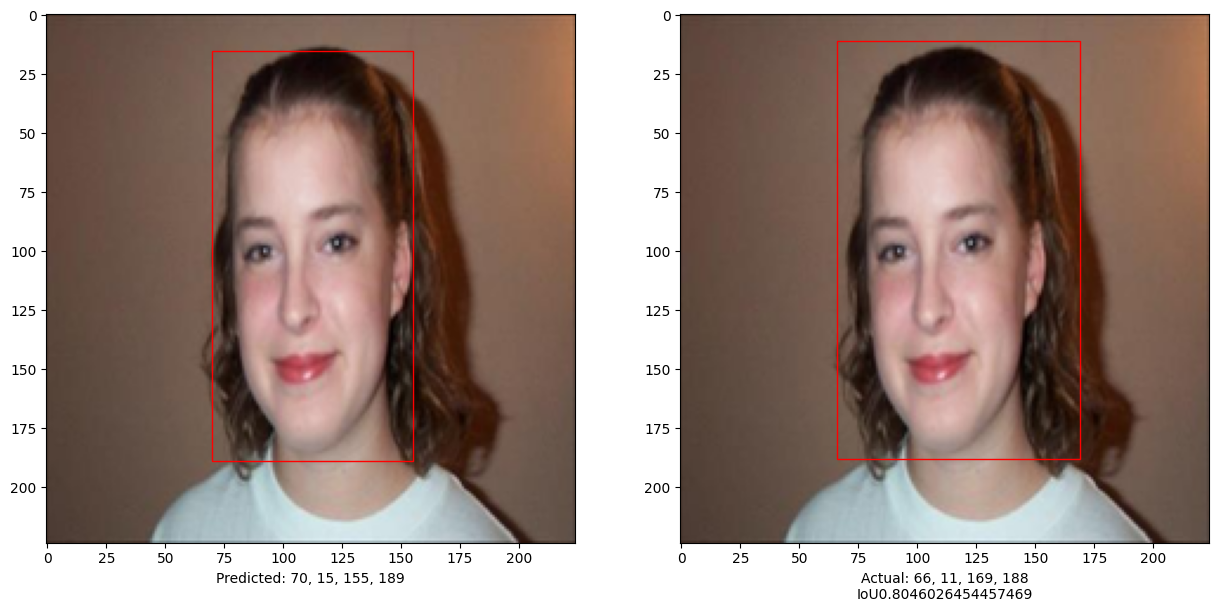

In [ ]:
import matplotlib.patches as patches

# Saves the model in current path
vit_model.save("vit_object_detector_model.keras")


# To calculate IoU (intersection over union, given two bounding boxes)
def bounding_box_intersection_over_union(box_predicted, box_truth):
    # get (x, y) coordinates of intersection of bounding boxes
    top_x_intersect = max(box_predicted[0], box_truth[0])
    top_y_intersect = max(box_predicted[1], box_truth[1])
    bottom_x_intersect = min(box_predicted[2], box_truth[2])
    bottom_y_intersect = min(box_predicted[3], box_truth[3])

    # calculate area of the intersection bb (bounding box)
    intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(
        0, bottom_y_intersect - top_y_intersect + 1
    )

    # calculate area of the prediction bb and ground-truth bb
    box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (
        box_predicted[3] - box_predicted[1] + 1
    )
    box_truth_area = (box_truth[2] - box_truth[0] + 1) * (
        box_truth[3] - box_truth[1] + 1
    )

    # calculate intersection over union by taking intersection
    # area and dividing it by the sum of predicted bb and ground truth
    # bb areas subtracted by  the interesection area

    # return ioU
    return intersection_area / float(
        box_predicted_area + box_truth_area - intersection_area
    )


i, mean_iou = 0, 0

# Compare results for 10 images in the test set
for input_image in x_test[:10]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    im = input_image

    # Display the image
    ax1.imshow(im.astype("uint8"))
    ax2.imshow(im.astype("uint8"))

    input_image = cv2.resize(
        input_image, (img_size, img_size), interpolation=cv2.INTER_AREA
    )
    input_image = np.expand_dims(input_image, axis=0)
    preds = vit_model.predict(input_image)[0]

    (h, w) = (im).shape[0:2]

    top_left_x, top_left_y = int(preds[0] * w), int(preds[1] * h)

    bottom_right_x, bottom_right_y = int(preds[2] * w), int(preds[3] * h)

    box_predicted = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax1.add_patch(rect)
    ax1.set_xlabel(
        "Predicted: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
    )

    top_left_x, top_left_y = int(y_test[i][0] * w), int(y_test[i][1] * h)

    bottom_right_x, bottom_right_y = int(y_test[i][2] * w), int(y_test[i][3] * h)

    box_truth = top_left_x, top_left_y, bottom_right_x, bottom_right_y

    mean_iou += bounding_box_intersection_over_union(box_predicted, box_truth)
    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax2.add_patch(rect)
    ax2.set_xlabel(
        "Actual: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
        + "\n"
        + "IoU"
        + str(bounding_box_intersection_over_union(box_predicted, box_truth))
    )
    i = i + 1

print("mean_iou: " + str(mean_iou / len(x_test[:10])))
plt.show()